Using device: cpu

=== Training with SOFT boundary enforcement ===
[Soft] Epoch      0 | PDE: 6.903e+01 | BC: 7.443e-01 | Total: 7.647e+01
[Soft] Epoch   1000 | PDE: 5.990e-03 | BC: 6.047e-04 | Total: 1.204e-02
[Soft] Epoch   2000 | PDE: 9.970e-04 | BC: 2.117e-05 | Total: 1.209e-03
[Soft] Epoch   3000 | PDE: 5.044e-04 | BC: 1.374e-05 | Total: 6.418e-04
[Soft] Epoch   4000 | PDE: 3.561e-04 | BC: 1.209e-05 | Total: 4.770e-04
[Soft] Epoch   5000 | PDE: 3.038e-04 | BC: 8.142e-06 | Total: 3.852e-04
[Soft] Epoch   6000 | PDE: 2.601e-04 | BC: 6.284e-06 | Total: 3.229e-04
[Soft] Epoch   7000 | PDE: 1.932e-04 | BC: 4.951e-06 | Total: 2.427e-04
[Soft] Epoch   8000 | PDE: 1.350e-04 | BC: 3.958e-06 | Total: 1.746e-04
[Soft] Epoch   9000 | PDE: 1.517e-04 | BC: 3.202e-06 | Total: 1.837e-04
[Soft] Epoch  10000 | PDE: 1.093e-04 | BC: 3.044e-06 | Total: 1.397e-04
[Soft] Epoch  11000 | PDE: 9.465e-05 | BC: 2.362e-06 | Total: 1.183e-04
[Soft] Epoch  12000 | PDE: 3.818e-04 | BC: 2.635e-06 | Total: 4.081e-

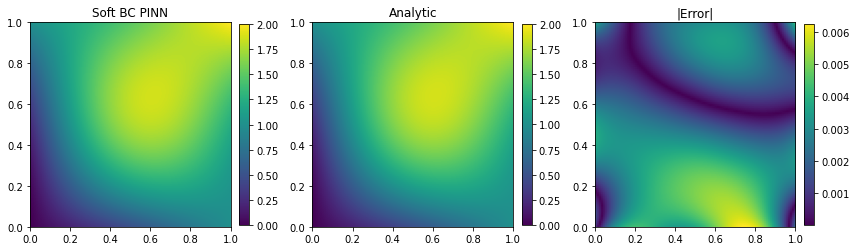

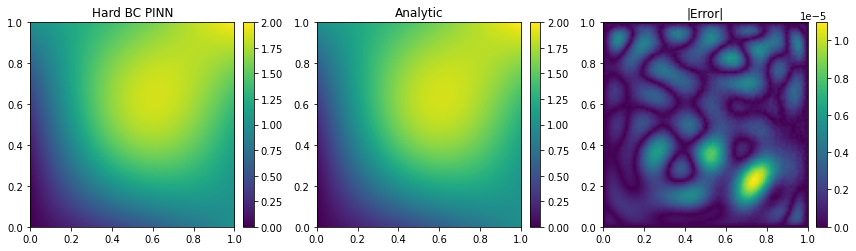

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 2D Poisson with Non-Zero Dirichlet BCs via PINNs (Soft vs Hard BCs)

PDE on Ω = (0,1)×(0,1):
    Δu(x,y) = f(x,y),   where Δ = ∂^2/∂x^2 + ∂^2/∂y^2

Choose an *analytic solution* so we know f and the boundary values exactly:
    u*(x,y) = x^2 + y + sin(π x) sin(π y)

Then
    Δu* = ∂^2/∂x^2 u* + ∂^2/∂y^2 u* = 2 - 2π^2 sin(π x) sin(π y)
Set f(x,y) = 2 - 2π^2 sin(π x) sin(π y).

Dirichlet boundary (non-zero on all sides):
    u(x,y) = u*(x,y) on ∂Ω.

We solve the same problem in two ways:

1) Soft BCs (penalty):
   - Train a network u_θ(x,y) on interior residual MSE(Δu_θ - f) plus a boundary penalty
     MSE(u_θ - g) with g = u*|∂Ω.

2) Hard BCs (boundary lifting / trial function):
   - Construct y_θ(x,y) = A(x,y) + B(x,y) N_θ(x,y),
     where A(x,y) matches the boundary data *exactly* (A|∂Ω = g),
           B(x,y) = x(1-x) y(1-y) vanishes on the boundary.
     Then train only on the interior residual for y_θ.

At the end of each run, we report the relative L2 error on a 100×100 grid and plot:
   - PINN solution,
   - Analytic solution,
   - Absolute error heatmap.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility and device
# -------------------------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------
# Exact data
# ----------
PI = torch.pi

def u_exact(xy):
    """
    Analytic solution u*(x,y) = x^2 + y + sin(pi x) sin(pi y).

    xy: (N,2) tensor with columns [x,y] in [0,1]^2.
    returns: (N,1)
    """
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return x**2 + y + torch.sin(PI*x) * torch.sin(PI*y)

def laplace_u_exact(xy):
    """
    Δu* = 2 - 2π^2 sin(π x) sin(π y).
    Used to define forcing f.
    """
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return 2.0 - 2.0*(PI**2) * torch.sin(PI*x) * torch.sin(PI*y)

def f_forcing(xy):
    """Alias for clarity: f = Δu*."""
    return laplace_u_exact(xy)

# ---------------------------
# Boundary data (closed form)
# ---------------------------
# For our u*(x,y) = x^2 + y + sin(pi x) sin(pi y), the boundary traces simplify:
# Left  (x=0): u = y
# Right (x=1): u = 1 + y
# Bottom(y=0): u = x^2
# Top   (y=1): u = x^2 + 1
# Corner values: (0,0)->0, (1,0)->1, (0,1)->1, (1,1)->2

def g_left(y):    return y
def g_right(y):   return 1.0 + y
def g_bottom(x):  return x**2
def g_top(x):     return x**2 + 1.0

g00, g10, g01, g11 = 0.0, 1.0, 1.0, 2.0  # corner values for transfinite interpolation

# ---------------------
# Network architecture
# ---------------------
class MLP2D(nn.Module):
    """
    Simple fully-connected network for scalar fields u(x,y) on [0,1]^2.
    Tanh activations are standard in PINNs due to smooth derivatives.
    """
    def __init__(self, in_dim=2, out_dim=1, hidden=64, depth=4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden))
        layers.append(nn.Tanh())
        for _ in range(depth - 2):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden, out_dim))
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, xy):
        return self.net(xy)

# --------------------------
# Differential operators Δu
# --------------------------
def laplacian(u, xy):
    """
    Compute Laplacian(u) = u_xx + u_yy with autograd.
    Inputs:
        u  : (N,1) output of model(xy) with graph retained
        xy : (N,2) inputs requiring grad
    returns:
        (N,1) tensor of Laplacian values
    """
    grads = torch.autograd.grad(
        u, xy, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]  # shape (N,2): [u_x, u_y]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]

    u_xx = torch.autograd.grad(
        u_x, xy, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1]

    u_yy = torch.autograd.grad(
        u_y, xy, grad_outputs=torch.ones_like(u_y), create_graph=True
    )[0][:, 1:2]

    return u_xx + u_yy

# ----------------------------
# Collocation / boundary samp.
# ----------------------------
def sample_interior(n):
    """
    Uniform random interior samples in (0,1)^2.
    """
    xy = torch.rand(n, 2, device=device)
    xy.requires_grad_(True)  # needed for autograd
    return xy

def sample_boundary(n_per_side):
    """
    Uniform random samples on each side of the unit square boundary.
    Returns:
        xb : (4*n_per_side, 2) boundary points
        gb : (4*n_per_side, 1) boundary values g at those points
    """
    t = torch.rand(n_per_side, 1, device=device)

    # Four sides: x=0, x=1, y=0, y=1
    left   = torch.cat([torch.zeros_like(t), t], dim=1)           # (0, t)
    right  = torch.cat([torch.ones_like(t),  t], dim=1)           # (1, t)
    bottom = torch.cat([t,                  torch.zeros_like(t)], dim=1)  # (t, 0)
    top    = torch.cat([t,                  torch.ones_like(t)],  dim=1)  # (t, 1)

    xb = torch.cat([left, right, bottom, top], dim=0)

    # Boundary values from closed forms
    gl = g_left(left[:, 1:2])
    gr = g_right(right[:, 1:2])
    gbm = g_bottom(bottom[:, 0:1])
    gt = g_top(top[:, 0:1])
    gb = torch.cat([gl, gr, gbm, gt], dim=0)

    return xb, gb

# -------------------------------------------------
# Hard-BC "lifting" functions A(x,y) and mask B(x,y)
# -------------------------------------------------
def B_mask(xy):
    """
    Vanishes on the entire boundary: x=0,1 or y=0,1.
    """
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return x*(1.0 - x)*y*(1.0 - y)

def A_lifting(xy):
    """
    Transfinite interpolation to match g on ∂Ω exactly.
    A(x,y) = (1-x) g_left(y) + x g_right(y)
           + (1-y) g_bottom(x) + y g_top(x)
           - corner correction terms to avoid double counting.

    This guarantees A equals the desired Dirichlet data on each side.
    """
    x = xy[:, 0:1]
    y = xy[:, 1:2]

    term_edges = (1.0 - x) * g_left(y) + x * g_right(y) \
               + (1.0 - y) * g_bottom(x) + y * g_top(x)

    # Bilinear corner blending to subtract double-counted corners:
    term_corners = (1.0 - x)*(1.0 - y) * g00 \
                 + x*(1.0 - y) * g10 \
                 + (1.0 - x)*y * g01 \
                 + x*y * g11

    return term_edges - term_corners

# ----------------------
# Training configurations
# ----------------------
class TrainConfig:
    def __init__(self,
                 n_int=2048,   # interior collocation points per epoch
                 n_bc=256,     # boundary points per side per epoch (total 4*n_bc)
                 lr=1e-3,
                 epochs=20000,
                 bc_weight=10.0,  # only used for soft BCs
                 resample_every=200):
        self.n_int = n_int
        self.n_bc = n_bc
        self.lr = lr
        self.epochs = epochs
        self.bc_weight = bc_weight
        self.resample_every = resample_every

# -----------------------
# Training: SOFT BOUNDARY
# -----------------------
def train_soft_bc(cfg):
    """
    Train u_theta with soft boundary penalty:
        Loss = MSE(Δu_theta - f) + λ * MSE(u_theta|∂Ω - g)
    """
    model = MLP2D(hidden=64, depth=4).to(device)
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    # Initial batches
    xy_int = sample_interior(cfg.n_int)         # interior points (require grad)
    xb, gb = sample_boundary(cfg.n_bc)          # boundary points (no grad needed)

    for ep in range(cfg.epochs):
        opt.zero_grad()

        # PDE residual on interior
        u_int = model(xy_int)
        lap_u = laplacian(u_int, xy_int)
        res_pde = lap_u - f_forcing(xy_int)
        loss_pde = torch.mean(res_pde**2)

        # Boundary penalty
        xb_req = xb.detach().clone()
        xb_req.requires_grad_(False)
        u_b = model(xb_req)
        loss_bc = torch.mean((u_b - gb)**2)

        loss = loss_pde + cfg.bc_weight * loss_bc
        loss.backward()
        opt.step()

        # Periodically resample collocation points to reduce grid overfitting
        if (ep + 1) % cfg.resample_every == 0:
            xy_int = sample_interior(cfg.n_int)
            xb, gb = sample_boundary(cfg.n_bc)

        if ep % 1000 == 0:
            print(f"[Soft] Epoch {ep:6d} | PDE: {loss_pde.item():.3e} | BC: {loss_bc.item():.3e} | Total: {loss.item():.3e}")

    return model

# ----------------------
# Training: HARD BOUNDARY
# ----------------------
class HardBCWrapper(nn.Module):
    """
    Wrap a base network N_theta and produce y_theta(x,y) = A(x,y) + B(x,y) * N_theta(x,y),
    which satisfies Dirichlet BCs exactly (A|∂Ω = g, B|∂Ω = 0).
    """
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, xy):
        return A_lifting(xy) + B_mask(xy) * self.base(xy)

def train_hard_bc(cfg):
    """
    Train y_theta with hard boundary enforcement:
        y_theta(x,y) = A(x,y) + B(x,y) * N_theta(x,y)
        Loss = MSE(Δy_theta - f)   (no boundary term)
    """
    base = MLP2D(hidden=64, depth=4).to(device)
    model = HardBCWrapper(base).to(device)
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    xy_int = sample_interior(cfg.n_int)

    for ep in range(cfg.epochs):
        opt.zero_grad()

        y_int = model(xy_int)
        lap_y = laplacian(y_int, xy_int)
        res_pde = lap_y - f_forcing(xy_int)
        loss_pde = torch.mean(res_pde**2)

        loss_pde.backward()
        opt.step()

        if (ep + 1) % cfg.resample_every == 0:
            xy_int = sample_interior(cfg.n_int)

        if ep % 1000 == 0:
            print(f"[Hard] Epoch {ep:6d} | PDE: {loss_pde.item():.3e}")

    return model

# ---------------
# Evaluation utils
# ---------------
def eval_on_grid(model, nx=100, ny=100):
    """
    Evaluate model and analytic solution on a regular grid for visualization and error.
    Returns:
        X, Y : meshgrid arrays (ny,nx)
        Uhat : model prediction (ny,nx)
        Utru : analytic (ny,nx)
        relL2: relative L2 error on the grid
    """
    xs = torch.linspace(0, 1, nx, device=device)
    ys = torch.linspace(0, 1, ny, device=device)
    X, Y = torch.meshgrid(xs, ys, indexing='xy')
    XY = torch.stack([X.flatten(), Y.flatten()], dim=1)

    with torch.no_grad():
        Uhat = model(XY).reshape(nx, ny).T  # reshape back; transpose to (ny,nx)
        Utru = u_exact(XY).reshape(nx, ny).T

    num = torch.linalg.norm((Uhat - Utru).reshape(-1), ord=2)
    den = torch.linalg.norm(Utru.reshape(-1), ord=2)
    relL2 = (num/den).item()

    # Move to CPU numpy for plotting
    return X.cpu().numpy(), Y.cpu().numpy(), Uhat.cpu().numpy(), Utru.cpu().numpy(), relL2

def plot_fields(X, Y, Uhat, Utru, title_prefix=""):
    """
    Three-panel figure: PINN, Analytic, |Error|.
    """
    err = np.abs(Uhat - Utru)

    plt.figure(figsize=(12, 3.6))

    plt.subplot(1,3,1)
    im1 = plt.imshow(Uhat, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.title(f"{title_prefix} PINN")
    plt.colorbar(im1, fraction=0.046, pad=0.04)

    plt.subplot(1,3,2)
    im2 = plt.imshow(Utru, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.title("Analytic")
    plt.colorbar(im2, fraction=0.046, pad=0.04)

    plt.subplot(1,3,3)
    im3 = plt.imshow(err, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.title("|Error|")
    plt.colorbar(im3, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# --------
# Main run
# --------
def main():
    # Training configs (tuned for clarity; increase epochs/width for higher accuracy)
    cfg_soft = TrainConfig(n_int=2048, n_bc=256, lr=1e-3, epochs=15000, bc_weight=10.0, resample_every=200)
    cfg_hard = TrainConfig(n_int=2048, n_bc=0,    lr=1e-3, epochs=15000, bc_weight=0.0,  resample_every=200)

    print("\n=== Training with SOFT boundary enforcement ===")
    model_soft = train_soft_bc(cfg_soft)

    print("\n=== Training with HARD boundary enforcement ===")
    model_hard = train_hard_bc(cfg_hard)

    # Evaluate and plot
    print("\n=== Evaluation on 100x100 grid ===")
    X, Y, Uhat_soft, Utru, rel_soft = eval_on_grid(model_soft, nx=100, ny=100)
    _, _, Uhat_hard, _, rel_hard     = eval_on_grid(model_hard, nx=100, ny=100)

    print(f"Relative L2 error (Soft BC): {rel_soft:.3e}")
    print(f"Relative L2 error (Hard BC): {rel_hard:.3e}")

    plot_fields(X, Y, Uhat_soft, Utru, title_prefix="Soft BC")
    plot_fields(X, Y, Uhat_hard, Utru, title_prefix="Hard BC")

if __name__ == "__main__":
    main()
